In [1]:
import gymnasium as gym
import numpy as np

# 各状態の分割数
NUM_DIZITIZED = 6

# 学習パラメータ
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数

class State:
    def __init__(self, num_states, num_actions):
        # 行動数を取得
        self.num_actions = num_actions

        # Qテーブルを作成　(分割数^状態数)×(行動数)
        self.q_table = np.random.uniform(low=-1, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        # 観測した状態デジタル変換する閾値を求める
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def analog2digitize(self, observation):
        #状態の離散化
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        # 状態の離散化
        state = self.analog2digitize(observation)
        state_next = self.analog2digitize(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        # Qテーブルを更新(Q学習)
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        # ε-greedy法で行動を選択する
        state = self.analog2digitize(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            # 最も価値の高い行動を行う。
            action = np.argmax(self.q_table[state][:])
        else:
            # 適当に行動する。
            action = np.random.choice(self.num_actions)
        return action

In [2]:
class Agent:
    def __init__(self, num_states, num_actions):
        # 環境を生成
        self.state = State(num_states, num_actions)

    def update_Q_function(self, observation, action, reward, observation_next):
        # Qテーブルの更新
        self.state.update_Q_table(observation, action, reward, observation_next)

    def get_action(self, observation, step):
        # 行動
        action = self.state.decide_action(observation, step)
        return action

In [52]:
from matplotlib import animation

# 最大のステップ数
MAX_STEPS = 500
# 最大の試行回数
NUM_EPISODES = 10000

class Environment():
    def __init__(self, toy_env):
        # 環境を生成
        self.env = gym.make(toy_env)
        # 状態数を取得
        num_states = self.env.observation_space.shape[0]
        # 行動数を取得
        num_actions = self.env.action_space.n
        # Agentを生成
        self.agent = Agent(num_states, num_actions)

    def run(self):
        complete_episodes = 0 # 成功数
        step_list = []
        is_episode_final = False  # 最後の試行
        frames = []  # 画像を保存する変数

        # 試行数分繰り返す
        for episode in range(NUM_EPISODES):
            observation, _ = self.env.reset()  # 環境の初期化
            for step in range(MAX_STEPS):
                action = self.agent.get_action(observation, episode)
                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, term, trunc, _ = self.env.step(action)
                # 報酬を与える
                if term:
                    reward = -1  # 失敗したので-1の報酬を与える
                    complete_episodes = 0  # 成功数をリセット
                elif trunc:
                    print(f"{episode}: truncated {step}")
                    reward = 2  # 成功したので+1の報酬を与える
                    complete_episodes += 1  # 連続成功記録を更新
                else:
                    reward = 0
                # Qテーブルを更新する
                self.agent.update_Q_function(observation, action, reward, observation_next)
                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if term or trunc:
                    step_list.append(step+1)
                    break

        return step_list, frames

In [53]:
TOY = "CartPole-v1"

cartpole = Environment(TOY)
step_list = cartpole.run()

212: truncated 499
226: truncated 499
243: truncated 499
253: truncated 499
324: truncated 499
336: truncated 499
337: truncated 499
338: truncated 499
339: truncated 499
340: truncated 499
341: truncated 499
343: truncated 499
344: truncated 499
345: truncated 499
346: truncated 499
347: truncated 499
348: truncated 499
349: truncated 499
350: truncated 499
351: truncated 499
352: truncated 499
353: truncated 499
354: truncated 499
355: truncated 499
357: truncated 499
358: truncated 499
360: truncated 499
370: truncated 499
373: truncated 499
375: truncated 499
377: truncated 499
378: truncated 499
388: truncated 499
432: truncated 499
434: truncated 499
435: truncated 499
436: truncated 499
437: truncated 499
438: truncated 499
439: truncated 499
440: truncated 499
442: truncated 499
443: truncated 499
446: truncated 499
448: truncated 499
450: truncated 499
451: truncated 499
453: truncated 499
454: truncated 499
596: truncated 499
642: truncated 499
688: truncated 499
775: truncat

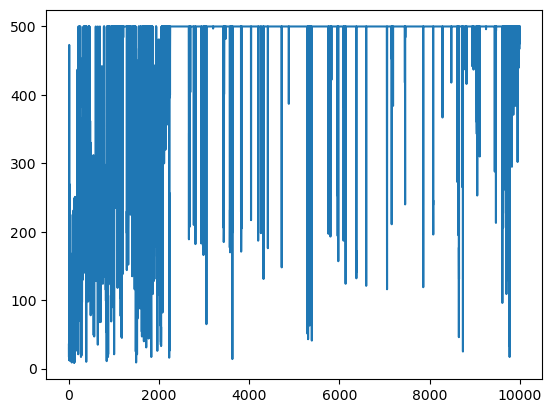

In [55]:
import matplotlib.pyplot as plt

plt.plot(step_list[0])